In [2]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re




In [ ]:
import dask.dataframe as dd
import csv

csv_path = "../data/raw/complaints.csv"
parquet_path = "../data/raw/complaints_dask.parquet"

# Define dtypes explicitly
dtypes = {
    'Complaint ID': 'float64',
    'Date received': 'object',
    'Product': 'object',
    'Sub-product': 'object',
    'Issue': 'object',
    'Sub-issue': 'object',
    'Consumer complaint narrative': 'object',
    'Company public response': 'object',
    'Company': 'object',
    'State': 'object',
    'ZIP code': 'object',
    'Tags': 'object',
    'Consumer consent provided?': 'object',
    'Submitted via': 'object',
    'Date sent to company': 'object',
    'Company response to consumer': 'object',
    'Timely response?': 'object',
    'Consumer disputed?': 'object'
}

# Load CSV with Dask
ddf = dd.read_csv(
    csv_path,
    dtype=dtypes,
    on_bad_lines='skip',
    quoting=csv.QUOTE_MINIMAL,
    escapechar='\\',
    engine='python',
    assume_missing=True  # helpful if there are NaNs in numeric cols
)

# Parse date columns explicitly
ddf['Date received'] = dd.to_datetime(ddf['Date received'], errors='coerce')
ddf['Date sent to company'] = dd.to_datetime(ddf['Date sent to company'], errors='coerce')

# Save as parquet for faster reloads later
ddf.to_parquet(parquet_path, engine="pyarrow", write_index=False)

# Optional: print out a sample to verify
print(ddf.head())         


## Import libraries and load data

In [4]:
# Load and preview the Parquet file
df = dd.read_parquet("../data/raw/complaints_dask.parquet")
df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-05-24,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,<NA>,<NA>,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MN,55303,<NA>,<NA>,Web,2025-05-24,In progress,Yes,<NA>,13700800.0
1,2025-05-24,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,<NA>,<NA>,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77338,<NA>,<NA>,Web,2025-05-24,In progress,Yes,<NA>,13701501.0
2,2025-04-01,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Was not notified of investigation status or re...,<NA>,<NA>,Experian Information Solutions Inc.,GA,XXXXX,<NA>,<NA>,Web,2025-05-13,In progress,Yes,<NA>,12767170.0
3,2025-05-21,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,<NA>,<NA>,"EQUIFAX, INC.",MD,20706,<NA>,<NA>,Web,2025-05-21,Closed with non-monetary relief,Yes,<NA>,13636012.0
4,2025-05-30,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,<NA>,<NA>,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,35811,<NA>,<NA>,Web,2025-05-30,In progress,Yes,<NA>,13815634.0


## Basic Info & Null Counts

In [5]:
print("Total Rows:", len(df))
print("\nData Types:\n", df.dtypes)

# Show missing values
missing = df.isnull().sum().compute()
print("\nMissing Values:\n", missing)


Total Rows: 933041

Data Types:
 Date received                    datetime64[ns]
Product                         string[pyarrow]
Sub-product                     string[pyarrow]
Issue                           string[pyarrow]
Sub-issue                       string[pyarrow]
Consumer complaint narrative    string[pyarrow]
Company public response         string[pyarrow]
Company                         string[pyarrow]
State                           string[pyarrow]
ZIP code                        string[pyarrow]
Tags                            string[pyarrow]
Consumer consent provided?      string[pyarrow]
Submitted via                   string[pyarrow]
Date sent to company             datetime64[ns]
Company response to consumer    string[pyarrow]
Timely response?                string[pyarrow]
Consumer disputed?              string[pyarrow]
Complaint ID                            float64
dtype: object

Missing Values:
 Date received                       46
Product                         

## Distribution of complaints across Products

C:\Users\user\AppData\Local\Temp\ipykernel_12944\2813739740.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


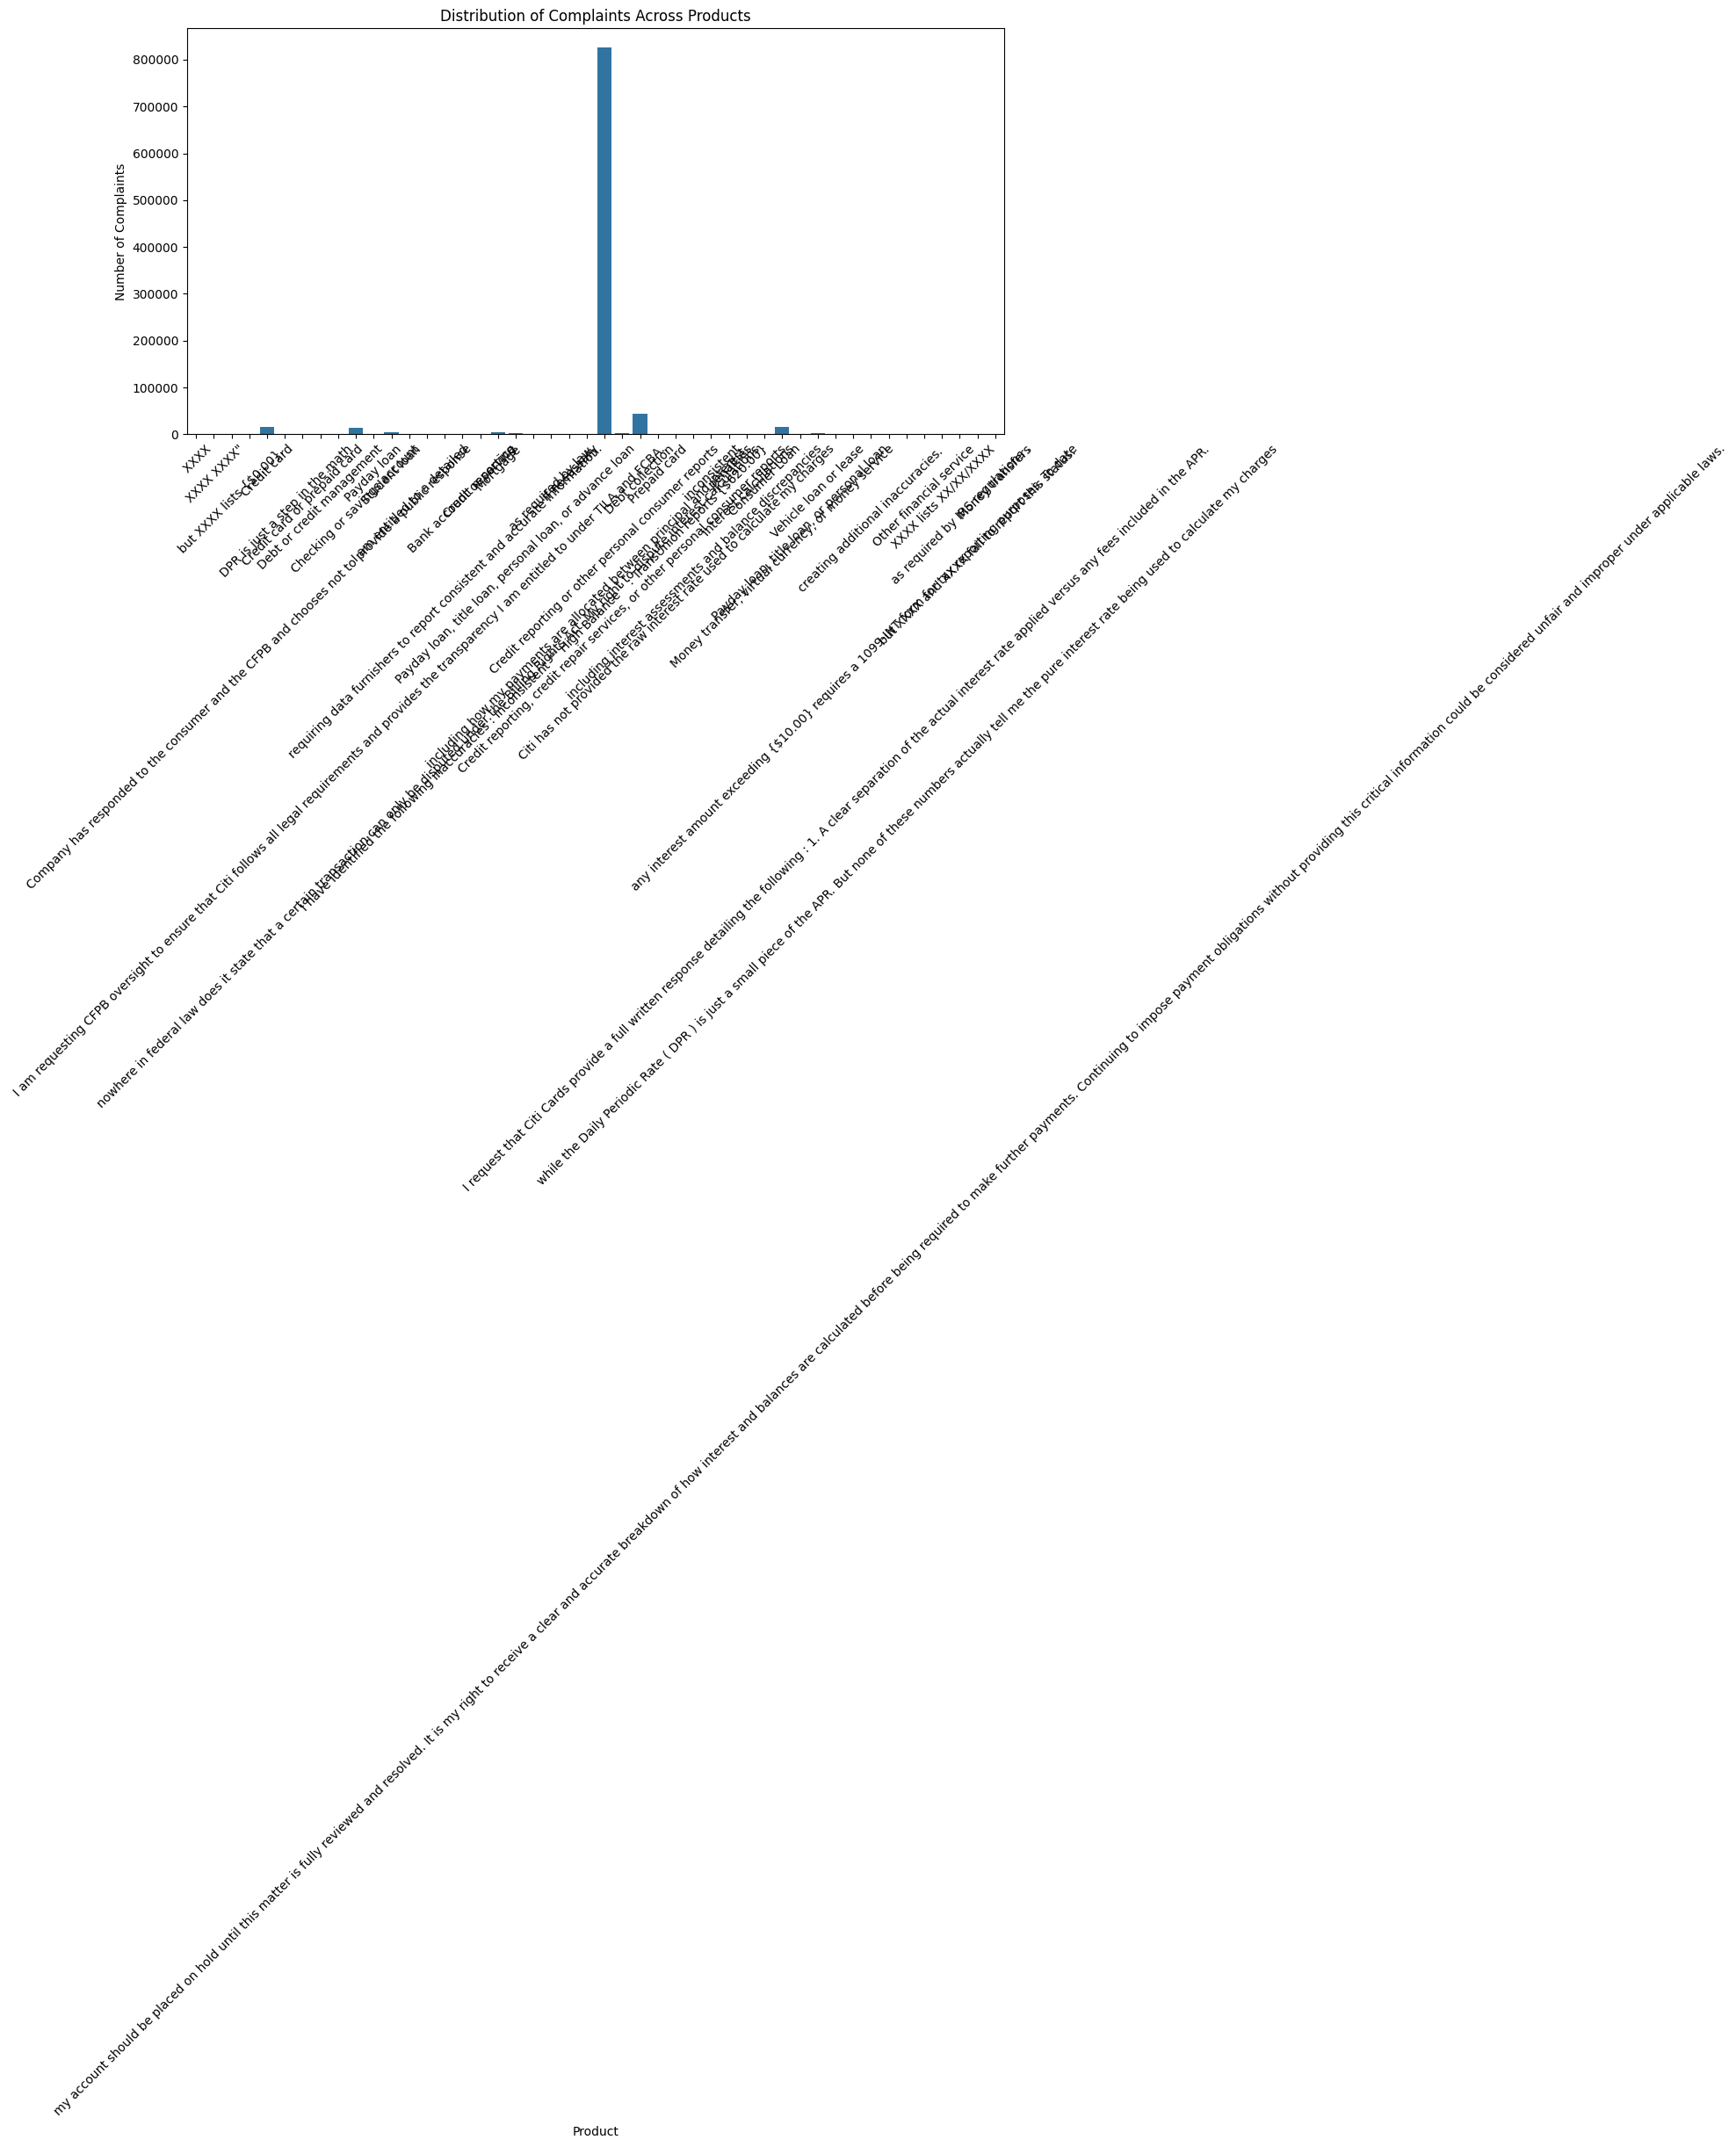

In [6]:
# Count complaints per product
product_counts = df['Product'].value_counts().compute()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Complaints Across Products")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()



## Length of Consumer complaint narratives

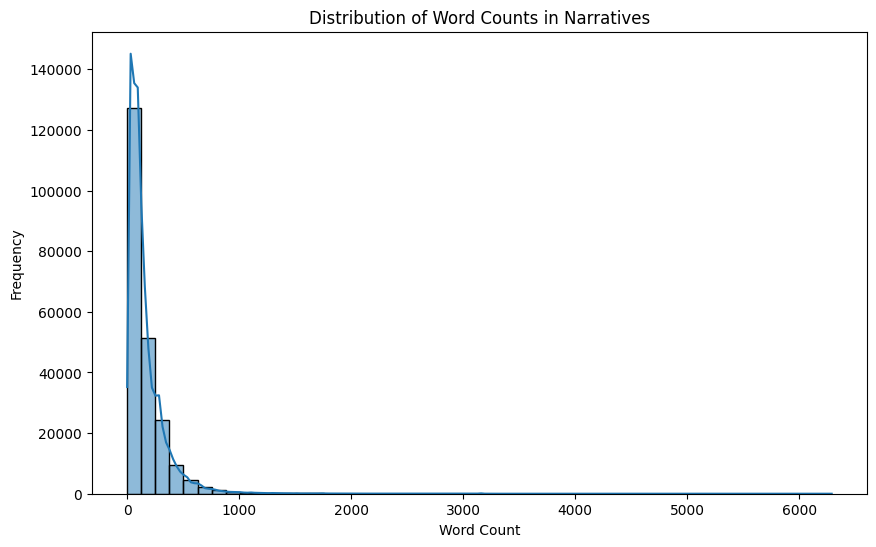

Narrative Word Count Stats:
count    222274.000000
mean        165.644664
std         198.043251
min           1.000000
25%          56.000000
50%         107.000000
75%         206.000000
max        6291.000000
Name: word_count, dtype: float64


In [7]:
# Drop rows with missing narratives
narrative_df = df[~df['Consumer complaint narrative'].isnull()]

# Compute word counts
narrative_df = narrative_df.assign(
    word_count=narrative_df['Consumer complaint narrative'].str.split().str.len()
)

# Convert to pandas for plotting
narrative_pd = narrative_df[['word_count']].compute()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(narrative_pd['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts in Narratives")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Show stats
print("Narrative Word Count Stats:")
print(narrative_pd['word_count'].describe())



## Count narratives with and without text

In [9]:
# With narrative
with_narrative = df['Consumer complaint narrative'].notnull().sum().compute()

# Without narrative
without_narrative = df['Consumer complaint narrative'].isnull().sum().compute()

print(f"✅ Complaints with narrative: {with_narrative}")
print(f"❌ Complaints without narrative: {without_narrative}")


✅ Complaints with narrative: 222274
❌ Complaints without narrative: 710767


## Filter for target products and remove empty narratives

In [ ]:
target_products = [
    "Credit card",
    "Personal loan",
    "Buy Now, Pay Later (BNPL)",
    "Savings account",ne44k  
    "Money transfers"
]

# Filter
filtered_df = df[
    (df['Product'].isin(target_products)) &
    (df['Consumer complaint narrative'].notnull())
]


## Clean the text (lowercase, remove special chars, etc.)

In [10]:
# Define cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove special chars
    text = re.sub(r"\bi am writing to file a complaint\b", "", text)
    return text.strip()

# Apply cleaning using map_partitions
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].map_partitions(
    lambda part: part.apply(clean_text),
    meta=('Consumer complaint narrative', 'object')
)


## Save cleaned & filtered data to CSV

In [11]:
output_path = "../data/filtered_complaints.csv"
filtered_df[['Product', 'cleaned_narrative']].to_csv(output_path, single_file=True, index=False)
print(f"✅ Filtered and cleaned data saved to {output_path}")


✅ Filtered and cleaned data saved to ../data/filtered_complaints.csv
